# Mobile Ad Anti-Fraud Algorithm Challenge - Modeling Part Ⅱ

## 移动广告反欺诈算法挑战赛 数据建模 Ⅱ
2019 科大讯飞 A.I.开发者挑战赛

-- Date:   02 Sept 2019  
-- Author:   Arianna.H

___

## 5.Modeling - catboost

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"  #display multiple outputs in one cell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import auc
#!pip install catboost
#!pip install --user --upgrade catboost
from catboost import CatBoostClassifier, Pool, cv  #catboost
from catboost.utils import get_roc_curve
from catboost import MetricVisualizer  #plot metric

In [19]:
import catboost
catboost.__version__

'0.16.4'

In [2]:
df = pd.read_csv('round1_iflyad_anticheat_train_clean_cat.csv')

In [3]:
df.shape
df.head(3)

(1000000, 46)

,label,pkgname,ver,adunitshowid,mediashowid,apptype,ip,city,province,reqrealip,...,hw_ratio,inch,osv_clean,osv_top1,osv_top2,osv_top3,ver_clean,ver_top1,ver_top2,ver_top3
0,1,2d2664e827bcbb8b07100c7fbe072e9b,11.11.0,907d0f8c29663840491577a21c7b612a,ca64a500000d84c8fcb8a0587d0e1e0c,280.0,183.197.47.83,石家庄市,河北省,180.76.181.7,...,2.2,859.1,810,8,81,810,11110,1,11,111
1,1,empty,NaN,10199dc8fea2e173525bc3151bd84312,3f2fc57a6e1f9c6fa4464c25cc1e88a3,319.0,106.34.14.149,开封市,河南省,47.95.111.138,...,0.5,0.0,9,9,9,9,0,0,0,0
2,0,16b81f93f4b1a35cebbf15f07683f171,3.2.1.0524.1958,83f2ecfe65f936f5f2ed59f8e8ff1d01,eea7280e1a2313e4c2e89290b01d196c,273.0,223.104.16.151,长春市,吉林省,39.96.159.155,...,2.0,0.0,810,8,81,810,32105241958,3,32,321


___

Fix null value

In [4]:
null_value_stats = df.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

ver         321824
city         15193
province     55973
osv          12997
lan         367527
dtype: int64

In [5]:
def cols_to_fix():
    for c in df.columns:
        if df[c].dtype == "object":
            df[c] = df[c].fillna("nan")
        else:
            df[c] = df[c].fillna(0.0)

cols_to_fix()

In [6]:
traindata_x = df.drop(['label'],axis=1)
traindata_y = df['label']

One of the special characteristics of CatBoost model is the ability to tackle non-numeric data directly. We do not need to do any convertion of categorical data which is a must for other algorithms like randomforest, logistic regression, etc.  

Separate categorical/nominal columns as we need to specify them in the CatBoost model. 

In [9]:
catCol = ['pkgname', 'ver', 'adunitshowid', 'mediashowid', 'apptype', 'ip',
       'city', 'province', 'reqrealip', 'adidmd5', 'imeimd5', 'openudidmd5',
       'macmd5', 'dvctype', 'model', 'make', 'ntt', 'carrier', 'os', 'osv',
       'orientation', 'lan',  'date', 'dayofweek', 'hour',
       'minute', 'hourtosecond', 'ip_top', 'reqrealip_top', 'apptype_top1',
       'apptype_top2',  'osv_clean', 'osv_top1',
       'osv_top2', 'osv_top3', 'ver_clean', 'ver_top1', 'ver_top2',
       'ver_top3']

In [10]:
def ConvertToCat():
    for var in catCol:
        traindata_x[var] = traindata_x[var].astype('category')
ConvertToCat()

In [11]:
print(traindata_x.dtypes)

pkgname          category
ver              category
adunitshowid     category
mediashowid      category
apptype          category
ip               category
city             category
province         category
reqrealip        category
adidmd5          category
imeimd5          category
openudidmd5      category
macmd5           category
dvctype          category
model            category
make             category
ntt              category
carrier          category
os               category
osv              category
orientation      category
lan              category
h                 float64
w                 float64
ppi               float64
date             category
dayofweek        category
hour             category
minute           category
hourtosecond     category
ip_top           category
reqrealip_top    category
apptype_top1     category
apptype_top2     category
h_w               float64
hw_ratio          float64
inch              float64
osv_clean        category
osv_top1    

### indicate categorical columns

In [12]:
categorical_features_indices = np.where(traindata_x.dtypes == 'category')[0]
categorical_features_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 25, 26, 27, 28, 29, 30, 31, 32, 33, 37, 38, 39,
       40, 41, 42, 43, 44], dtype=int64)

### Split train and validation set

In [13]:
x_train,x_test,y_train,y_test = train_test_split(traindata_x,traindata_y,train_size=.9,random_state=20,shuffle=True)

In [14]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(900000, 45) (900000,) (100000, 45) (100000,)


___

## 6.Tune Catboost Model

### Simple Model

In [34]:
model = CatBoostClassifier(
    loss_function='Logloss',
    custom_loss=['Logloss', 'AUC'],
    eval_metric='F1',
    iterations=150,
    learning_rate=0.4,
    random_state=20, 
    verbose=10,
    train_dir='it_150_lr_0.4'
    #use_best_model=False
)
print('Model params:')
print(model.get_params())
print()
print('Staring training catboost model...')
model.fit(
    x_train, y_train,
    eval_set=(x_test,y_test),
    cat_features=categorical_features_indices
)
print('Best score is:')
print(model.best_score_)
print('Best iteration is: '+ str(model.best_iteration_))
# print('Tree counts of Catboost with best parameters: ' + str(model.tree_count_))

In [ ]:
# you can save model information for using next time without re-runing it
model.save_model('catboost_model.dump')
model = CatBoostClassifier()
model.load_model('catboost_model.dump')

### Training with cv

In [26]:
params = {
    'loss_function':'Logloss',
    'custom_metric':['Logloss', 'AUC'],
    'iterations': 500,
    'learning_rate': 0.1,
    'eval_metric': 'F1',
    'random_seed': 20,
    'use_best_model':True
}

In [27]:
start=time.perf_counter()
print('Start training cv model...')
print()
cv_data = cv(
    params = params,
    pool = Pool(traindata_x, label=traindata_y, cat_features=categorical_features_indices),
    fold_count=3,
    shuffle=True,
    partition_random_seed=20,
    stratified=False,
    verbose=10
)
end=time.perf_counter()
print()
print('Time consuming: {:.2f}min'.format((end-start)/60))

Start training cv model...

0:	learn: 0.9019838	test: 0.9046348	best: 0.9046348 (0)	total: 21.2s	remaining: 2h 56m 29s
10:	learn: 0.9184758	test: 0.9225637	best: 0.9225637 (10)	total: 3m 48s	remaining: 2h 49m 33s
20:	learn: 0.9228003	test: 0.9261618	best: 0.9261618 (20)	total: 7m 43s	remaining: 2h 56m 6s
30:	learn: 0.9245322	test: 0.9282521	best: 0.9282521 (30)	total: 12m 1s	remaining: 3h 1m 54s
40:	learn: 0.9252673	test: 0.9290518	best: 0.9290518 (40)	total: 16m 17s	remaining: 3h 2m 18s
50:	learn: 0.9263197	test: 0.9299111	best: 0.9299111 (50)	total: 20m 22s	remaining: 2h 59m 23s
60:	learn: 0.9270366	test: 0.9305007	best: 0.9305007 (60)	total: 24m 27s	remaining: 2h 56m 2s
70:	learn: 0.9275113	test: 0.9309147	best: 0.9309166 (68)	total: 28m 24s	remaining: 2h 51m 37s
80:	learn: 0.9280130	test: 0.9314620	best: 0.9314620 (80)	total: 32m 27s	remaining: 2h 47m 53s
90:	learn: 0.9285783	test: 0.9319354	best: 0.9319354 (90)	total: 36m 5s	remaining: 2h 42m 10s
100:	learn: 0.9291497	test: 0.9324

In [33]:
best_value = np.max(cv_data['test-F1-mean'])
best_iter = np.argmax(cv_data['test-F1-mean'])
print('Model params:')
print(params) 
print()
print('Best validation F1 score of cv model: {:.6f}±{:.4f}'.format(
    best_value,
    cv_data['test-F1-std'][best_iter])
)
print('Best validation Logloss of cv model: {:.6f}±{:.4f}'.format(
    np.max(cv_data['test-Logloss-mean']),
    cv_data['test-Logloss-std'][best_iter])
)
print('Best validation AUC of cv model: {:.6f}±{:.4f}'.format(
    np.max(cv_data['test-AUC-mean']),
    cv_data['test-AUC-std'][best_iter])
)
print('Best iteration: {}'.format(best_iter))
cv_data.head()

Model params:
{'loss_function': 'Logloss', 'custom_metric': ['Logloss', 'AUC'], 'iterations': 500, 'learning_rate': 0.1, 'eval_metric': 'F1', 'random_seed': 20, 'use_best_model': True}

Best validation F1 score of cv model: 0.936554±0.0002
Best validation Logloss of cv model: 0.576101±0.0006
Best validation AUC of cv model: 0.985125±0.0001
Best iteration: 499


,iterations,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.904635,0.000390,0.901984,0.000612,0.576101,0.000204,0.577309,0.000655,0.958149,0.000669
1,1,0.906132,0.002957,0.904032,0.001926,0.483626,0.003378,0.486290,0.003456,0.966608,0.001205
2,2,0.909752,0.001971,0.907047,0.001036,0.416538,0.001749,0.419862,0.001501,0.968959,0.000331
3,3,0.911698,0.001893,0.909141,0.000588,0.365799,0.003243,0.370070,0.002723,0.970377,0.000497
4,4,0.915003,0.001260,0.911628,0.000500,0.324008,0.006229,0.329716,0.005565,0.972545,0.000904


### Overfitting detector (early stopping)

In [15]:
start=time.perf_counter()
model_with_early_stop = CatBoostClassifier(
    loss_function='Logloss',
    custom_loss=['Logloss', 'AUC'],
    eval_metric='F1',
    iterations=500,
    random_seed=20,
    learning_rate=0.1,
    early_stopping_rounds=20,
    train_dir='it_500_lr_0.1'
)

print('Staring training catboost model...')
model_with_early_stop.fit(
    x_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(x_test, y_test),
    verbose=10
)
end=time.perf_counter()
print()
print('Time consuming: {:.2f}min'.format((end-start)/60))

Staring training catboost model...
0:	learn: 0.9014496	test: 0.9040733	best: 0.9040733 (0)	total: 4.17s	remaining: 34m 42s
10:	learn: 0.9199248	test: 0.9245672	best: 0.9245672 (10)	total: 54.7s	remaining: 40m 29s
20:	learn: 0.9239455	test: 0.9276165	best: 0.9276165 (20)	total: 1m 50s	remaining: 42m 11s
30:	learn: 0.9259582	test: 0.9295252	best: 0.9296335 (29)	total: 2m 56s	remaining: 44m 26s
40:	learn: 0.9270137	test: 0.9304274	best: 0.9304274 (40)	total: 3m 55s	remaining: 43m 53s
50:	learn: 0.9279284	test: 0.9311954	best: 0.9311954 (50)	total: 4m 53s	remaining: 43m 3s
60:	learn: 0.9288623	test: 0.9319872	best: 0.9319872 (60)	total: 5m 56s	remaining: 42m 47s
70:	learn: 0.9292382	test: 0.9326317	best: 0.9326749 (68)	total: 6m 51s	remaining: 41m 25s
80:	learn: 0.9298903	test: 0.9329703	best: 0.9329703 (80)	total: 7m 52s	remaining: 40m 43s
90:	learn: 0.9303594	test: 0.9333166	best: 0.9333166 (90)	total: 8m 44s	remaining: 39m 16s
100:	learn: 0.9307108	test: 0.9335643	best: 0.9335643 (100)	


Time consuming: 35.82min

Model params:


NameError: name 'model' is not defined

In [16]:
print('Model params:')
print(model_with_early_stop.get_params())
print()
print('Best score is:')
print(model_with_early_stop.best_score_)
print('Best iteration is: '+ str(model_with_early_stop.best_iteration_))
print('Tree counts of Catboost with best parameters: ' + str(model_with_early_stop.tree_count_))

Model params:
{'iterations': 500, 'learning_rate': 0.1, 'loss_function': 'Logloss', 'random_seed': 20, 'train_dir': 'it_500_lr_0.1', 'custom_loss': ['Logloss', 'AUC'], 'eval_metric': 'F1', 'early_stopping_rounds': 20}

Best score is:
{'learn': {'Logloss': 0.1591147718794998, 'F1': 0.934599361877029}, 'validation': {'Logloss': 0.15473743586425584, 'F1': 0.9363383335591948, 'AUC': 0.9849992111102392}}
Best iteration is: 284
Tree counts of Catboost with best parameters: 285


### Plot auc

In [37]:
validate_pool = Pool(x_test, y_test, cat_features=categorical_features_indices)
curve = get_roc_curve(model_with_early_stop, validate_pool)
(fpr, tpr, thresholds) = curve
roc_auc = auc(fpr, tpr)

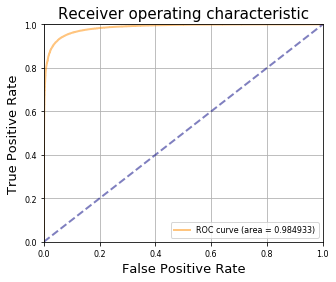

In [38]:
_=plt.figure(figsize=(5, 4))
lw = 2
_=plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.6f)' % roc_auc, alpha=0.5)
_=plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)
_=plt.xlim([0.0, 1.0])
_=plt.ylim([0.0, 1.0])
_=plt.xticks(fontsize=8)
_=plt.yticks(fontsize=8)
_=plt.grid(True)
_=plt.xlabel('False Positive Rate', fontsize=13)
_=plt.ylabel('True Positive Rate', fontsize=13)
_=plt.title('Receiver operating characteristic', fontsize=15)
_=plt.legend(loc="lower right", fontsize=8)
_=plt.show()

### Graphing Metrics (F1, LogLoss, AUC) and comparing between models

In [36]:
MetricVisualizer(['it_200_lr_0.7','it_300_lr_0.3','it_200_lr_0.5','it_500_lr_0.1']).start()

<img style="float: left;" src="Catboost-F1-plot.png" width=70%> 

### Best scores on different parameters
1)  
'it_200_lr_0.7'  
Model params:  
{'iterations': 200, 'learning_rate': 0.7}  
Best score is:  
{'validation': {'Logloss': 0.16177110710959713, 'F1': 0.9328283669052772, 'AUC': 0.9836359552616086}}  

2)  
'it_300_lr_0.3'   
Model params:  
{'iterations': 300, 'learning_rate': 0.3}  
Best score is:  
{'validation': {'Logloss': 0.15979496946276414, 'F1': 0.9335764902042518, 'AUC': 0.9840637573668797}}  

3)  
'it_200_lr_0.5_'  
Model params:  
{'iterations': 200, 'learning_rate': 0.5}  
Best score is:  
{'validation': {'Logloss': 0.16158135498462647, 'F1': 0.933329170959115, 'AUC': 0.983678392330355}}  
Best iteration is: 196  
Tree counts of Catboost with best parameters: 197  

4)  
'it_500_lr_0.1'
Model params:  
{'iterations': 500, 'learning_rate': 0.1,early_stopping_rounds=20}  
Best score is:  
{'validation': {'Logloss': 0.15473743586425584, 'F1': 0.9363383335591948, 'AUC': 0.9849992111102392}}  
Best iteration is: 284  
Tree counts of Catboost with best parameters: 285  
Time consuming: 35.82min  

5)  
**==> BEST  
Model params:     
{'iterations': 500, 'learning_rate': 0.1, 'cv': 3}  
Best validation F1 score of cv model: 0.936554±0.0002  
Best validation Logloss of cv model: 0.576101±0.0006  
Best validation AUC of cv model: 0.985125±0.0001  
Best iteration: 499  
Time consuming: 203.09min**  

____

## 7.Compare best performance between models

Best F1 scores on validation set:

lgb = 0.936973 > CatBoost = 0.936554 > rf = 0.933681